# 1: PROJECT OVERVIEW

In [2]:
# !pip install plotly==4.9.0

Note: you may need to restart the kernel to use updated packages.


# 2: IMPORT LIBRARIES/DATASETS

In [1]:
#import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
# %cd /content/drive/My Drive/Scene_Classification

# 3: DATA EXPLORATION AND DATA VISUALIZATION:

In [3]:
# Check the number of images in training, validation and test dataset

train = []
test = []

#os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('./seg_train'):
  train_class = os.listdir(os.path.join('seg_train',i))
  train.extend(train_class)
  test_class = os.listdir(os.path.join('seg_test',i))
  test.extend(test_class)

print('Number of train images : {} \nNumber of test images : {}'.format(len(train),len(test)))


Number of train images : 14034 
Number of test images : 3000


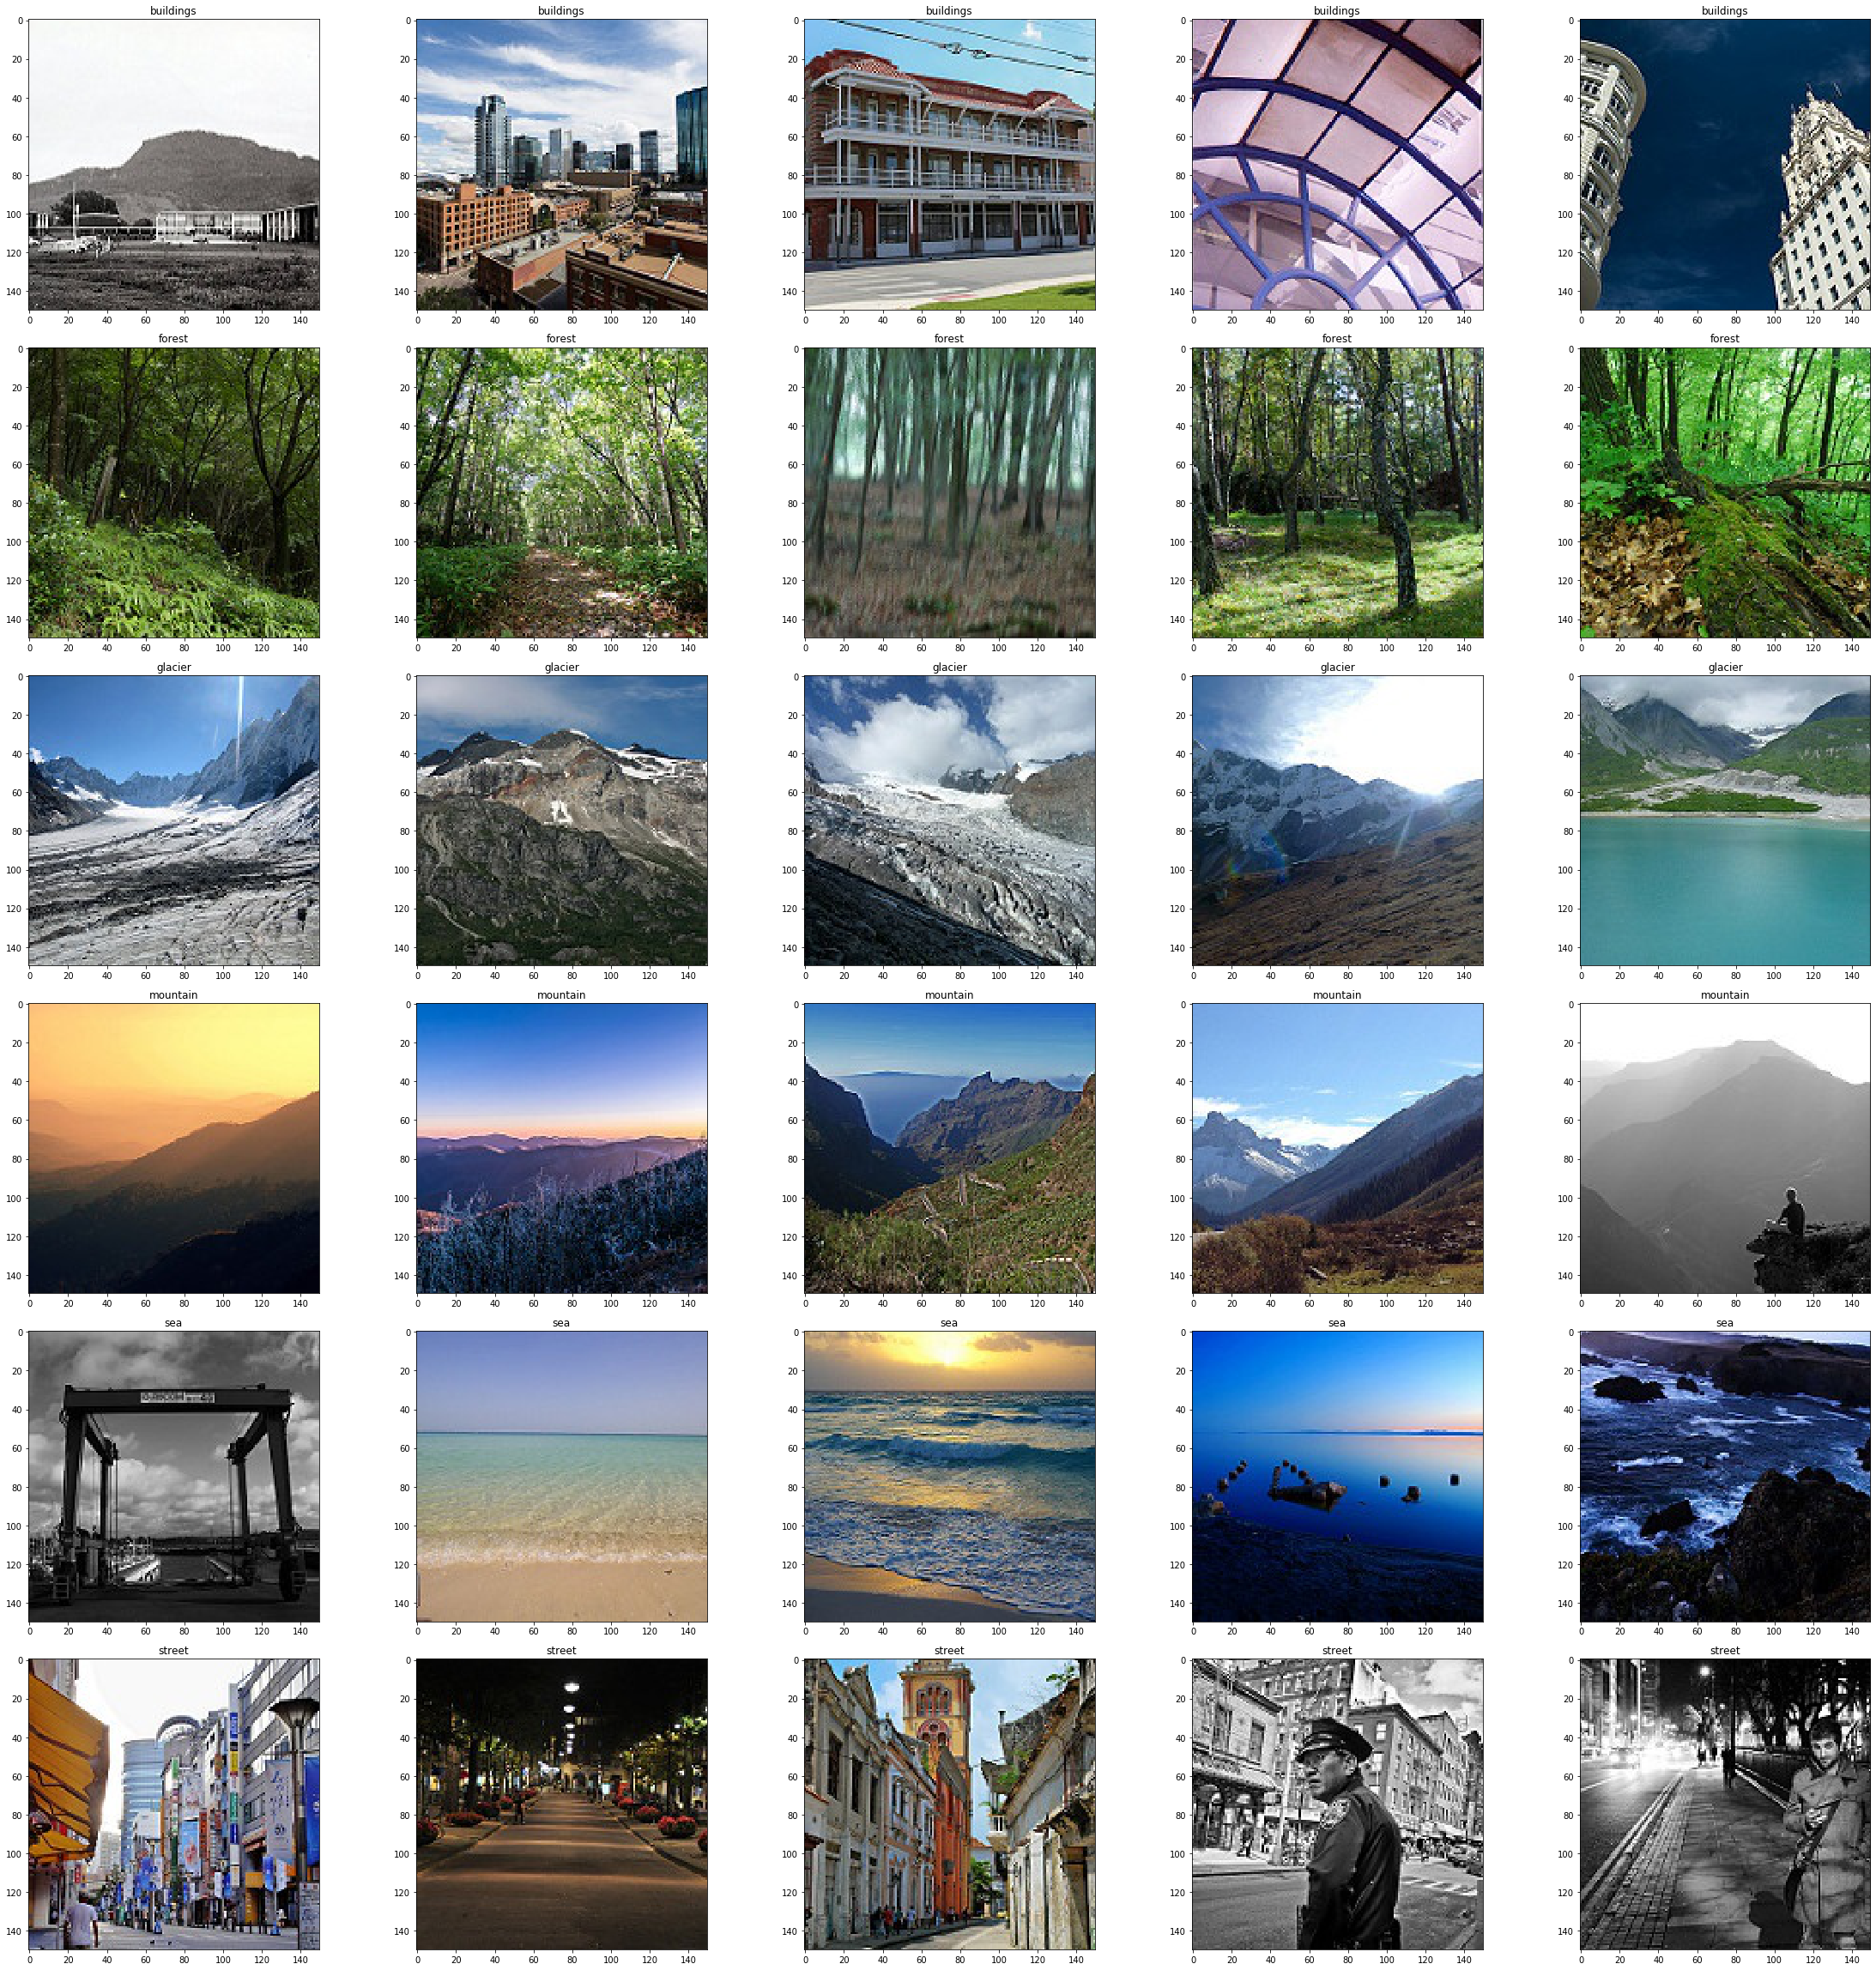

In [4]:
#Visualize the images in the dataset

fig, axs = plt.subplots(6,5, figsize=(32,32))
count = 0
for i in os.listdir('./seg_train'):
  # get the list of images in the particualr class
  train_class = os.listdir(os.path.join('seg_train',i))
  #plot 5 images per class
  for j in range(5):
    img = os.path.join('seg_train',i,train_class[j])
    
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1

fig.tight_layout()


In [13]:
#check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
for i in os.listdir('./seg_train'):
  train_class = os.listdir(os.path.join('seg_train',i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i,len(train_class)))

Number of images in buildings = 2191 

Number of images in forest = 2271 

Number of images in glacier = 2404 

Number of images in mountain = 2512 

Number of images in sea = 2274 

Number of images in street = 2382 



In [14]:
data = [go.Pie(labels = Class_name, values = No_images_per_class)]
fig = go.Figure(data = data)
iplot(fig)

#### FINDING THE NUMBER OF IMAGES PER CLASS IN TEST DATA AND CREATE A SIMILAR KIND OF PIE CHART 

In [15]:
No_images_per_class = []
Class_name = []
for i in os.listdir('./seg_test'):
  test_class = os.listdir(os.path.join('seg_test',i))
  No_images_per_class.append(len(test_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i,len(test_class)))

Number of images in buildings = 437 

Number of images in forest = 474 

Number of images in glacier = 553 

Number of images in mountain = 525 

Number of images in sea = 510 

Number of images in street = 501 



In [16]:
data = [go.Pie(labels = Class_name, values = No_images_per_class)]
fig = go.Figure(data = data)
iplot(fig)

# 4: PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR:

In [21]:
#create run-time augmentation on training and test dataset
#For training datagenerator,we add normalization ,shear angle, zooming range and horizontal flip
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.15,
        horizontal_flip=True)

#For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
#Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_directory(
        'seg_train',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        subset ='training')

validation_generator = train_datagen.flow_from_directory(
        'seg_train',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        subset ='validation')

test_generator = test_datagen.flow_from_directory(
        'seg_test',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 11932 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.



### ADDING MORE AUGMENTATION TO THE TRAINING DATA AND INCREASE THE SIZE OF VALIDATION SET BY A FACTOR OF 2.

HINT: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator




In [23]:
tf.keras.preprocessing.image.ImageDataGenerator(
      featurewise_center=False,
      samplewise_center=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      zca_whitening=False,
      zca_epsilon=1e-06,
      rotation_range=0,
      width_shift_range=0.0,
      height_shift_range=0.0,
      brightness_range=None,
      shear_range=0.0,
      zoom_range=0.0,
      channel_shift_range=0.0,
      fill_mode="nearest",
      cval=0.0,
      horizontal_flip=False,
      vertical_flip=False,
      rescale=None,
      preprocessing_function=None,
      data_format=None,
      validation_split=0.3,
      dtype=None)

# 5: UNDERSTANDING THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS (CNN) AND RESIDUAL BLOCKS :

# 6: BUILD ResNet-18 Model

In [24]:
def res_block(X, filter, stage):
  #Convolutional_block

  X_copy = X

  f1 , f2, f3 = filter
  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  #Short path

  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 1

  X_copy = X


  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 2

  X_copy = X


  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [25]:

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# 5- stage

X = res_block(X, filter= [512,512,2048], stage= 5)

#Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dense(6, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

### REMOVING THE MAXPOOL LAYERS FROM RESIDUAL BLOCKS AND ADD DROPOUT LAYERS TO THE MODEL. COMPARING THEIR PERFORMANCE




In [26]:
def res_block(X, filter, stage):
  #Convolutional_block

  X_copy = X

  f1 , f2, f3 = filter
  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
 # X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  #Short path

  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  #X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 1

  X_copy = X


  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 2

  X_copy = X


  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
#X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# 5- stage

X = res_block(X, filter= [512,512,2048], stage= 5)

#Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dropout(0.4)(X)
X = Dense(6, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

# 7: COMPILE AND TRAIN DEEP LEARNING MODEL

In [12]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])


In [ ]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 50, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/50
372/372 [==============================] - ETA: 0s - loss: 1.2489 - accuracy: 0.5879
Epoch 00001: val_loss improved from inf to 2.34360, saving model to weights.hdf5
372/372 [==============================] - 3183s 9s/step - loss: 1.2489 - accuracy: 0.5879 - val_loss: 2.3436 - val_accuracy: 0.2740
Epoch 2/50
372/372 [==============================] - ETA: 0s - loss: 0.7102 - accuracy: 0.7498
Epoch 00002: val_loss did not improve from 2.34360
372/372 [==============================] - 209s 562ms/step - loss: 0.7102 - accuracy: 0.7498 - val_loss: 3.0480 - val_accuracy: 0.3861
Epoch 3/50
372/372 [==============================] - ETA: 0s - loss: 0.6048 - accuracy: 0.7865
Epoch 00003: val_loss improved from 2.34360 to 0.66451, saving model to weights.hdf5
372/372 [==============================] - 212s 569ms/step - loss: 0.6048 - accuracy: 0.7865 - val_loss: 0.6645 - val_accuracy: 0.7577
Epoch 4/50
372/372 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.8

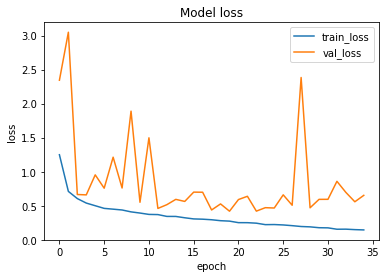

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

 USING DIFFERENT OPTIMIZER TO TRAIN THE MODEL .
- CHANGE THE VALUE OF PATIENCE IN EARLY STOPPING.


Try optimizers like adam, ndam
Change the value of patience to 25

In [13]:
model.load_weights("weights.hdf5")

# 8: ASSESS THE PERFORMANCE OF THE TRAINED MODEL:

In [ ]:
#Evaluate the performance of the model
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
93/93 [==============================] - 14s 150ms/step - loss: 0.3735 - accuracy: 0.8663
Accuracy Test : 0.8662634491920471


In [14]:
#assigning label names to the corresponding indexes
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3:'mountain', 4: 'sea', 5:'street'}

In [15]:
#loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

prediction = []
original = []
image = []
count = 0
for i in os.listdir('./seg_test'):
  for item in os.listdir(os.path.join('./seg_test',i)):
    #code to open the image
    img= PIL.Image.open(os.path.join('./seg_test',i,item))
    #resizing the image to (256,256)
    img = img.resize((256,256))
    #appending image to the image list
    image.append(img)
    #converting image to array
    img = np.asarray(img, dtype= np.float32)
    #normalizing the image
    img = img / 255
    #reshaping the image in to a 4D array
    img = img.reshape(-1,256,256,3)
    #making prediction of the model
    predict = model.predict(img)
    #getting the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    #appending the predicted class to the list
    prediction.append(labels[predict])
    #appending original class to the list
    original.append(i)


In [ ]:
#Getting the test accuracy 
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8613333333333333


In [17]:
#visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#classiication report
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

   buildings       0.84      0.91      0.87       437
      forest       0.95      0.97      0.96       474
     glacier       0.88      0.68      0.77       553
    mountain       0.72      0.93      0.81       525
         sea       0.92      0.87      0.90       510
      street       0.93      0.84      0.88       501

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.86      3000
weighted avg       0.87      0.86      0.86      3000



Text(0.5, 1.0, 'Confusion_matrix')

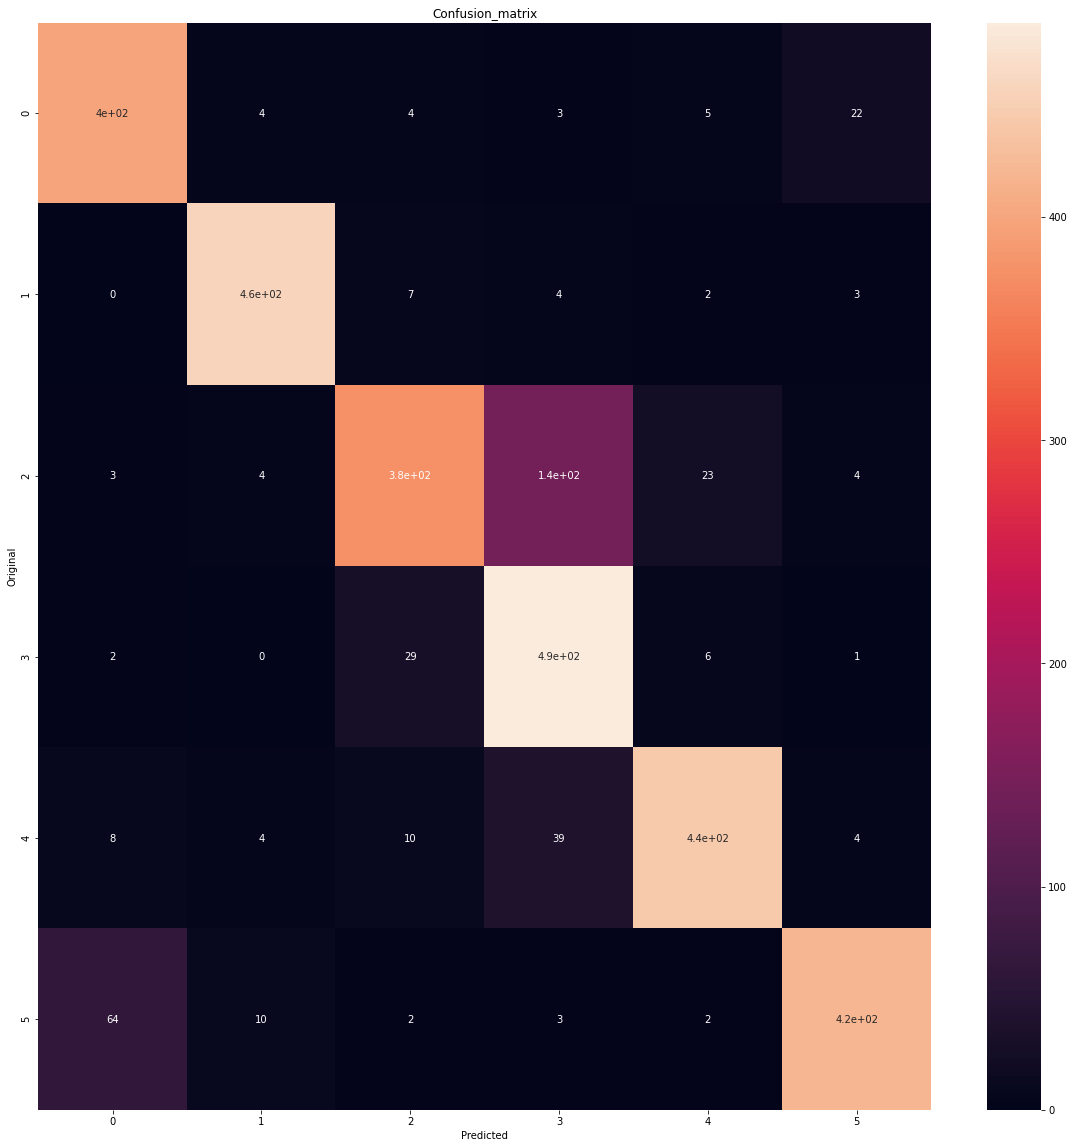

In [ ]:
#plotting confusion matrix

plt.figure(figsize=(20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')


#### WHY IS THE MODEL PERFORMING POORLY ON DETECTING GLACIERS?

If you could see the images, glaciers contain mountains.This might be the issue

# 9: VISUALIZING ACTIVATION MAPS THROUGH GRAD-CAM:

In [30]:
def grad_cam(img):

  #Covert the image to array of type float32
  img = np.asarray(img, dtype= np.float32)

  #Reshape the image from (256,256,3) to (1,256,256,3)
  img = img.reshape(-1,256,256,3)
  img_scaled = img / 255

  #Name of the layers we added to the base_model, you can find this in the model summaty
  #Every-time you run the model, check the summary, as the name would change or to avoid it 
  #you can add name to each layer
  classification_layers = ["Averagea_Pooling","Dense_final"]

  #Last convolutional layer in the base mdel, this woun't change as name has been already assigned to it.
  final_conv = model.get_layer("res_5_identity_2_c")

  #Create a model with original model input as input and the last conv_layer as the output
  final_conv_model = keras.Model(model.inputs, final_conv.output)

  #Then,we create the input for classification layer, which is the output of last conv layer
  #In our case, output produced by the conv layer is of the shape (1,3,3,2048) 
  #Since, the classification input needs the features as input, we ignore the batch dimension

  classification_input = keras.Input(shape=final_conv.output.shape[1:])

  # We iterate through the classification layers, to get the final layer and then, append 
  #the layer as the output layer to the classification model.
  temp = classification_input
  for layer in classification_layers:
      temp = model.get_layer(layer)(temp)
  classification_model = keras.Model(classification_input, temp)


  #We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
  #corresponding to the predicted class
  with tf.GradientTape() as tape:
      # Pass the image through the base model and get the feature map 
      final_conv_output = final_conv_model(img_scaled)

      #Assign gradient tape to monitor the conv_output
      tape.watch(final_conv_output)
      
      #Pass the feature map through the classification model and use argmax to get the 
      #index of the predicted class and then use the index to get the value produced by final
      #layer for that class
      prediction = classification_model(final_conv_output)

      predicted_class = tf.argmax(prediction[0][0][0])

      predicted_class_value = prediction[:,:,:,predicted_class]
  
  #Get the gradient corresponding to the predicted class based on feature map.
  #which is of shape (1,3,3,2048)
  gradient = tape.gradient(predicted_class_value, final_conv_output)

  #Since we need the filter values (2048), we reduce the other dimensions, 
  #hich would result in a shape of (2048,)
  gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  #We then convert the feature map produced by last conv layer(1,6,6,1536) to (6,6,1536)

  final_conv_output = final_conv_output.numpy()[0]

  gradient_channels = gradient_channels.numpy()

  #We multiply the filters in the feature map produced by final conv layer by the 
  #filter values that are used to get the predicted class. By doing this we inrease the
  #value of areas that helped in making the prediction and lower the vlaue of areas, that 
  #did not contribute towards the final prediction
  for i in range(gradient_channels.shape[-1]):
      final_conv_output[:, :, i] *= gradient_channels[i]

  #We take the mean accross the channels to get the feature map
  heatmap = np.mean(final_conv_output, axis=-1)

  #Normalizing the heat map between 0 and 1, to visualize it
  heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # Rescaling and converting the type to int
  heatmap = np.uint8(255 * heatmap_normalized )

  # Create the colormap
  color_map = plt.cm.get_cmap('jet')

  # get only the rb features from the heatmap
  color_map = color_map(np.arange(256))[:, :3]
  heatmap = color_map[heatmap]

  #convert the array to image, resize the image and then convert to array
  heatmap = keras.preprocessing.image.array_to_img(heatmap)
  heatmap = heatmap.resize((256, 256))
  heatmap = np.asarray(heatmap, dtype = np.float32)

  # Add the heatmap on top of the original image
  final_img = heatmap * 0.4 + img[0]
  final_img = keras.preprocessing.image.array_to_img(final_img)

  return final_img, heatmap_normalized



In [38]:
#Visualize the images in the dataset
import random
fig, axs = plt.subplots(6,3, figsize=(16,32))
count = 0
for _ in range(6):
  i = random.randint(0,len(image))
  gradcam, heatmap = grad_cam(image[i])
  axs[count][0].title.set_text("Original -" + original[i])
  axs[count][0].imshow(image[i])
  axs[count][1].title.set_text("Heatmap") 
  axs[count][1].imshow(heatmap)
  axs[count][2].title.set_text("Prediction -" + prediction[i]) 
  axs[count][2].imshow(gradcam)  
  count += 1

fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

- SINCE THE MODEL IS PERFORMING POORLY ON DETECTING GLACIERS, USING GRAD-CAM TO SEE, WHERE THE MODEL IS FOCUSING WHILE MAKING PREDICTIONS

# 10:SAVE THE MODEL FOR DEPLOYMENT:

- We now need to save our trained model and it has to be saved in a SavedModel format.
- The model will have a version number and will be saved in a structured directory 
- tf.saved_model.save is a function used to build a saved model that is suitable for serving using Tensorflow Serving. 
- After the model is saved, we can now use TensorFlow Serving to start making inference requests using a specific version of our trained model "servable".
- Use SavedModel to save and load your model—variables, the graph, and the graph's metadata. 
- This is a language-neutral, recoverable, hermetic serialization format that enables higher-level systems and tools to produce, consume, and transform TensorFlow models.
          
- Check this out for more information: 
https://www.tensorflow.org/guide/saved_model

In [ ]:
import tempfile
import json

# Let's obtain a temporary storage directory
MODEL_DIR = tempfile.gettempdir()

In [ ]:
MODEL_DIR

'/tmp'

In [ ]:
# Let's specify the model version, choose #1 for now 
version = 1 

In [ ]:
# Let's join the temp model directory with our chosen version number 
# The expected result will be = '\tmp\version number'
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /tmp/1



In [ ]:
# Let's save the model using saved_model.save
# If the directory already exists, we will remove it using '!rm' 
# rm removes each file specified on the command line. 
import tensorflow.keras.backend as K
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model,
    export_path)


Already saved a model, cleaning up

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets


In [ ]:
!ls -l {export_path}

total 3312
drwxr-xr-x 2 root root    4096 Jun 22 20:12 assets
-rw-r--r-- 1 root root 3380216 Jun 22 20:12 saved_model.pb
drwxr-xr-x 2 root root    4096 Jun 22 20:12 variables


### 10.1: EXPLORE THE SAVED MODEL

- saved_model_cli will be used to explore MetaGraphDefs (the models) and SignatureDefs (the methods you can call) in our SavedModel. 
- A MetaGraph is a dataflow graph, plus its associated variables, assets, and signatures. 
- A signature is the set of inputs to and outputs from a graph.

In [ ]:
# Now we can view our saved model
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 256, 256, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense_final'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 6)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0622 20:13:12.886722 140507565123456 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/o

# 11: SERVE THE MODEL USING TENSORFLOW SERVING

## 11.1: Let's add tensorflow-model-server package to our list of packages 

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  18279      0 --:--:-- --:--:-- --:--:-- 18166
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.

## 11.2: Let's install tensorflow model server:

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.2.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


## 11.3: Let's run TensorFlow serving

- We will load our model and start making inferences (predictions) based on it.
- There are some important parameters:

  - rest_api_port: The port that you'll use for REST requests.
  - model_name: You'll use this in the URL of REST requests. You can choose any name
  - model_base_path: This is the path to the directory where you've saved your model.
  
- For more information regarding REST, check this out: 
https://www.codecademy.com/articles/what-is-rest
- REST is a revival of HTTP in which http commands have semantic meaning. 

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=scene_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

2020-06-22 20:13:28.252438: I tensorflow_serving/model_servers/server.cc:86] Building single TensorFlow model file config:  model_name: scene_model model_base_path: /tmp
2020-06-22 20:13:28.253187: I tensorflow_serving/model_servers/server_core.cc:464] Adding/updating models.
2020-06-22 20:13:28.253332: I tensorflow_serving/model_servers/server_core.cc:575]  (Re-)adding model: scene_model
2020-06-22 20:13:28.353671: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: scene_model version: 1}
2020-06-22 20:13:28.353838: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: scene_model version: 1}
2020-06-22 20:13:28.353922: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: scene_model version: 1}
2020-06-22 20:13:28.354051: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from: /tmp/1
2020-06-22 20:13:28.427710: I external/org_tensorfl

- **Congratulations! now we have successfully loaded a servable version of our model {name: scene_model version: 1}** 

## 11.4: Let's start making requests in TensorFlow Serving

In [ ]:
#Function to plot the image along with it's title
def show(idx, title):
  plt.figure()
  plt.imshow(image[idx])
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

In [ ]:
#Converting the images into np.arrays and appending to the list
img_array = []
for i in image:
  img = np.asarray(i, dtype = np.float32)
  img *= 1./255.
  img_array.append(img)

#Converting the list into an array
img_array = np.asarray(img_array)
img_array.shape

(3000, 256, 256, 3)

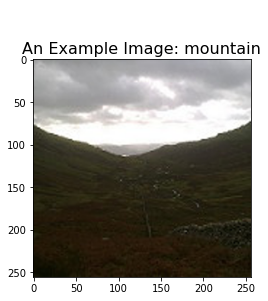

In [ ]:
#plot a random image in the dataset
rando = random.randint(0,len(image)-1)
show(rando, 'An Example Image: {}'.format(original[rando]))

In [ ]:
# Let's create a JSON object and make 3 inference requests
data = json.dumps({"signature_name": "serving_default", "instances": img_array[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 6975, 0.019607843831181526, 0.01568627543747425]]]]}


In [ ]:
!pip install -q requests

In [ ]:
import requests

headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/scene_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

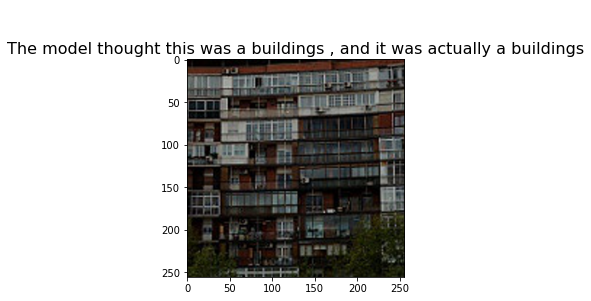

In [ ]:
show(0, 'The model thought this was a {} , and it was actually a {}'.format(
  labels[np.argmax(predictions[0])], original[0]))

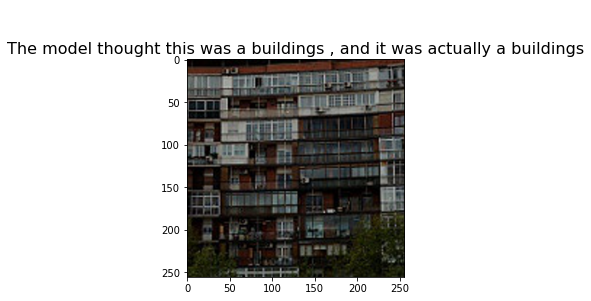

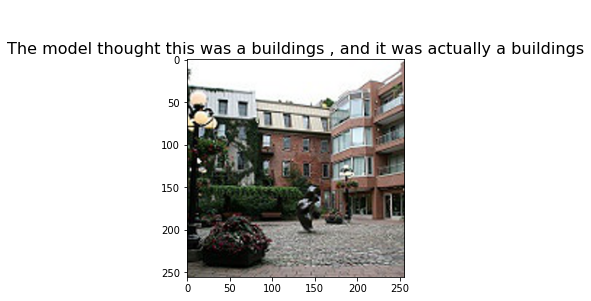

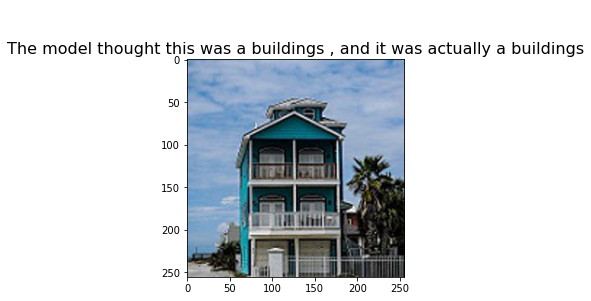

In [ ]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/scene_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  rando = random.randint(0,len(image)-1)
  show(i, 'The model thought this was a {} , and it was actually a {}'.format(
    labels[np.argmax(predictions[i])], original[i]))

### RUNNING INFERENCE OF RANDOM 5 IMAGES FROM THE TEST DATA.


In [ ]:
idx = random.randint(0,len(image)-1)

  data = json.dumps({"signature_name": "serving_default", "instances": img_array[idx:(idx+5)].tolist()})

  headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/scene_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,5):
  rando = random.randint(0,len(image)-1)
  show(i, 'The model thought this was a {} , and it was actually a {}'.format(
    labels[np.argmax(predictions[i])], original[i]))

# CONGRATULATIONS ON FINISHING THE PROJECT!